Comprendiamo insieme cosa possono contenere i file NetCDF e come possono essere gestiti con Python

## Prima di iniziare


### Librerie
Per raggiungere l'obiettivo userò principalmente `xarray`. In aggiunta userò `geopandas`, `datetime`, `pathlib` e `matplotlib`; quest'ultima per motivi di rappresentazione grafica dei dati.

In [1]:
from pathlib import Path
from datetime import datetime
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

### Fonti dati

Per questa attività userò i dati prelavati dal CAMS - [Copernicus Atmosphere Monitoring Service](https://atmosphere.copernicus.eu/) e da ISTAT. Come vedremo, i dati ISTAT li ho usati per riuscire ad orientarmi meglio con le mappe prodotte.


In [2]:
main_path = Path.cwd()
netcdf_path = main_path.joinpath('adaptor.cams_regional_fc.retrieve-1704441246.9534526-29460-11-5d3bb664-261d-4612-a637-a64b63cffaeb.nc')
boundaries_path = main_path.joinpath('Reg01012023_g').joinpath('Reg01012023_g_WGS84.shp')
pm10_img = main_path.joinpath('img_pm10')


## Contenuti
- [Il formato NetCDF](#il-formato-netcdf)
- [Workaround](#workaround)
- [PM10](#pm10)
- [Analisi delle 48h](#analisi-delle-48h)
- [Animazione dei dati](#animazione-dei-dati)
- [Conclusione](#conclusione)

## Il formato NetCDF

Il NetCDF è un formato file *array-oriented* spesso usato in campo scientifico, climatologico ed oceanografico. La particolarità di questo formato file sta nel fatto che i dati in esso contenuti, disposti sotto forma di matrici, riproducono sia la natura del fenomeno osservato che la sua temporalità. E' possibile storare in questo particolare tipo di formato file più fenomeni. Nel caso che andremo a vedere a breve, ad esempio, utilizzeremo un file `.nc` che contiene dati sia sul PM10 che sul SO2; entrambe le informazioni fanno riferimento allo stesso periodo temporale.

Per un approfondimento ulteriore ti rimando a [questa](https://confluence.ecmwf.int/display/CKB/What+are+NetCDF+files+and+how+can+I+read+them) pagina.

Di seguito utilizzerò `xarray` per leggere un NetCDF.

In [3]:
netcdf_data = xr.open_dataset(netcdf_path)

netcdf_data

<xarray.Dataset>
Dimensions:    (longitude: 125, latitude: 124, level: 3, time: 48)
Coordinates:
  * longitude  (longitude) float32 6.35 6.45 6.55 6.65 ... 18.55 18.65 18.75
  * latitude   (latitude) float32 47.25 47.15 47.05 46.95 ... 35.15 35.05 34.95
  * level      (level) float32 0.0 50.0 100.0
  * time       (time) timedelta64[ns] 00:00:00 01:00:00 ... 1 days 23:00:00
Data variables:
    pm10_conc  (time, level, latitude, longitude) float32 ...
    so2_conc   (time, level, latitude, longitude) float32 ...
Attributes:
    title:        PM10/SO2 Air Pollutant ANALYSIS at 3 levels
    institution:  Data produced by ENEA (Italy)
    source:       Data from MINNI model
    history:      Model MINNI ANALYSIS
    ANALYSIS:     Europe, 20231231-20240101+[0H_23H]
    summary:      MINNI model hourly ANALYSIS of PM10/SO2 concentration at 3 ...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

Il campo *Dimensions* contiene al suo interno il posizionamento geografico del dato, il riferimento temporale, che in questo caso corrisponde a 48h ed il `level` inteso come la quota di misurazione. Il dato che ho scaricato dal CAMS ha quindi una particolarità in più rispetto a quello che ho indicato in precedenza, oltre alla temporalità dello stesso c'è anche la quota altimetrica di misurazione(0, 50 e 100 metri). Come ho detto in precedenza, il formato NetCDF è *array-oriented*, può quindi gestire più domini purchè facciano riferimento alla stessa area geografica ed alla stessa temporalità.

Gli array li vediamo nel campo *Coordinates* e, in questo caso, vanno a definire il dominio spazio-temporale del dato.

Il dato in se, la concentrazione di inquinante, lo vediamo in *Data variables*.

*Indexes* ci mostra quali sono gli indici a cui possiamo fare riferimento per le nostre query.

*Attributes* è un campo abbastanza autoesplicativo.

## Workaround

Il periodo temporale di riferimento del dato che ho [scaricato](https://ads.atmosphere.copernicus.eu/cdsapp#!/search?type=dataset) è quello che va dal 31-12-2023 al 01-01-2024, le 48h riportate in *Dimensions*.

La variable temporale nel campo *Coordinates* è salvata come `timedelta64[ns]`, cioè un time delta in nanosecondi.

In [4]:
netcdf_date_range = netcdf_data.coords['time']

netcdf_date_range

<xarray.DataArray 'time' (time: 48)>
array([              0,   3600000000000,   7200000000000,  10800000000000,
        14400000000000,  18000000000000,  21600000000000,  25200000000000,
        28800000000000,  32400000000000,  36000000000000,  39600000000000,
        43200000000000,  46800000000000,  50400000000000,  54000000000000,
        57600000000000,  61200000000000,  64800000000000,  68400000000000,
        72000000000000,  75600000000000,  79200000000000,  82800000000000,
        86400000000000,  90000000000000,  93600000000000,  97200000000000,
       100800000000000, 104400000000000, 108000000000000, 111600000000000,
       115200000000000, 118800000000000, 122400000000000, 126000000000000,
       129600000000000, 133200000000000, 136800000000000, 140400000000000,
       144000000000000, 147600000000000, 151200000000000, 154800000000000,
       158400000000000, 162000000000000, 165600000000000, 169200000000000],
      dtype='timedelta64[ns]')
Coordinates:
  * time     (time) timedelta64[ns] 00:00:00 01:00:00 ... 1 days 23:00:00
Attributes:
    long_name:  ANALYSIS time from 20231231

Ho dovuto quindi preventivamente convertirlo in un formato più comprensibile, il `datetime64`.

In [5]:
netcdf_date_range = netcdf_date_range.values.astype('datetime64')

netcdf_date_range

array(['1970-01-01T00:00:00.000000000', '1970-01-01T01:00:00.000000000',
       '1970-01-01T02:00:00.000000000', '1970-01-01T03:00:00.000000000',
       '1970-01-01T04:00:00.000000000', '1970-01-01T05:00:00.000000000',
       '1970-01-01T06:00:00.000000000', '1970-01-01T07:00:00.000000000',
       '1970-01-01T08:00:00.000000000', '1970-01-01T09:00:00.000000000',
       '1970-01-01T10:00:00.000000000', '1970-01-01T11:00:00.000000000',
       '1970-01-01T12:00:00.000000000', '1970-01-01T13:00:00.000000000',
       '1970-01-01T14:00:00.000000000', '1970-01-01T15:00:00.000000000',
       '1970-01-01T16:00:00.000000000', '1970-01-01T17:00:00.000000000',
       '1970-01-01T18:00:00.000000000', '1970-01-01T19:00:00.000000000',
       '1970-01-01T20:00:00.000000000', '1970-01-01T21:00:00.000000000',
       '1970-01-01T22:00:00.000000000', '1970-01-01T23:00:00.000000000',
       '1970-01-02T00:00:00.000000000', '1970-01-02T01:00:00.000000000',
       '1970-01-02T02:00:00.000000000', '1970-01-02

Questo però ancora non è sufficiente ai miei scopi ed ho quindi creato una funzione che elimina i nanosecondi e mi restituisce la data e l'ora legata alla singola variabile. E' da notare che purtroppo questa tipologia di dato, nonostante il periodo temporale di riferimento fosse stato definito nel momento della ricerca dello stesso, parte dal 1 gennaio 1970.

In [6]:
def from_datetime64_to_datetime(input_value) -> datetime:
    to_string = str(input_value)
    drop_nanoseconds = to_string.split('.')[0]

    output_value = datetime.strptime(drop_nanoseconds, "%Y-%m-%dT%H:%M:%S")

    return output_value


In [7]:
min_date = from_datetime64_to_datetime(netcdf_date_range.min())
max_date = from_datetime64_to_datetime(netcdf_date_range.max())

min_date.date(), max_date.date()

(datetime.date(1970, 1, 1), datetime.date(1970, 1, 2))

Sono costretto quindi a crearmi una variabile `date_difference` che andrò ad usare per ottenere data ed ora di mio interesse grazie a `sensing_date`.

In [8]:
sensing_date = datetime.strptime("2023-12-31", "%Y-%m-%d")

date_difference = sensing_date - min_date

date_difference

datetime.timedelta(days=19722)

In [9]:
date_range = []
for x in netcdf_date_range:
    to_datetime = from_datetime64_to_datetime(x)
    target_date = to_datetime + date_difference

    date_range.append(target_date)
    
    
date_range

[datetime.datetime(2023, 12, 31, 0, 0),
 datetime.datetime(2023, 12, 31, 1, 0),
 datetime.datetime(2023, 12, 31, 2, 0),
 datetime.datetime(2023, 12, 31, 3, 0),
 datetime.datetime(2023, 12, 31, 4, 0),
 datetime.datetime(2023, 12, 31, 5, 0),
 datetime.datetime(2023, 12, 31, 6, 0),
 datetime.datetime(2023, 12, 31, 7, 0),
 datetime.datetime(2023, 12, 31, 8, 0),
 datetime.datetime(2023, 12, 31, 9, 0),
 datetime.datetime(2023, 12, 31, 10, 0),
 datetime.datetime(2023, 12, 31, 11, 0),
 datetime.datetime(2023, 12, 31, 12, 0),
 datetime.datetime(2023, 12, 31, 13, 0),
 datetime.datetime(2023, 12, 31, 14, 0),
 datetime.datetime(2023, 12, 31, 15, 0),
 datetime.datetime(2023, 12, 31, 16, 0),
 datetime.datetime(2023, 12, 31, 17, 0),
 datetime.datetime(2023, 12, 31, 18, 0),
 datetime.datetime(2023, 12, 31, 19, 0),
 datetime.datetime(2023, 12, 31, 20, 0),
 datetime.datetime(2023, 12, 31, 21, 0),
 datetime.datetime(2023, 12, 31, 22, 0),
 datetime.datetime(2023, 12, 31, 23, 0),
 datetime.datetime(2024, 1

Grazie a questo workaround posso finalmente vedere nel NetCDF il periodo temporale di mio interesse andando a sostituire quello calcolato con quello esistente nel file.

In [10]:
new_netcdf_data = netcdf_data.assign_coords({'time': date_range})

new_netcdf_data

<xarray.Dataset>
Dimensions:    (longitude: 125, latitude: 124, level: 3, time: 48)
Coordinates:
  * longitude  (longitude) float32 6.35 6.45 6.55 6.65 ... 18.55 18.65 18.75
  * latitude   (latitude) float32 47.25 47.15 47.05 46.95 ... 35.15 35.05 34.95
  * level      (level) float32 0.0 50.0 100.0
  * time       (time) datetime64[ns] 2023-12-31 ... 2024-01-01T23:00:00
Data variables:
    pm10_conc  (time, level, latitude, longitude) float32 ...
    so2_conc   (time, level, latitude, longitude) float32 ...
Attributes:
    title:        PM10/SO2 Air Pollutant ANALYSIS at 3 levels
    institution:  Data produced by ENEA (Italy)
    source:       Data from MINNI model
    history:      Model MINNI ANALYSIS
    ANALYSIS:     Europe, 20231231-20240101+[0H_23H]
    summary:      MINNI model hourly ANALYSIS of PM10/SO2 concentration at 3 ...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

## PM10

Abbiamo in precedenza detto che il formato file in questione può contenere diverse variabili a cui possono essere collegate diverse quote e tempi.

Di seguito estrarrò i dati della sola PM10 per la prima ora di misurazione a quota 0 metri.

In [11]:
single_data = new_netcdf_data[dict(level=[0], time=[0])]
single_data = single_data['pm10_conc']

single_data

<xarray.DataArray 'pm10_conc' (time: 1, level: 1, latitude: 124, longitude: 125)>
[15500 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 6.35 6.45 6.55 6.65 ... 18.55 18.65 18.75
  * latitude   (latitude) float32 47.25 47.15 47.05 46.95 ... 35.15 35.05 34.95
  * level      (level) float32 0.0
  * time       (time) datetime64[ns] 2023-12-31
Attributes:
    species:        PM10 Aerosol
    units:          µg/m3
    value:          hourly values
    standard_name:  mass_concentration_of_pm10_ambient_aerosol_in_air

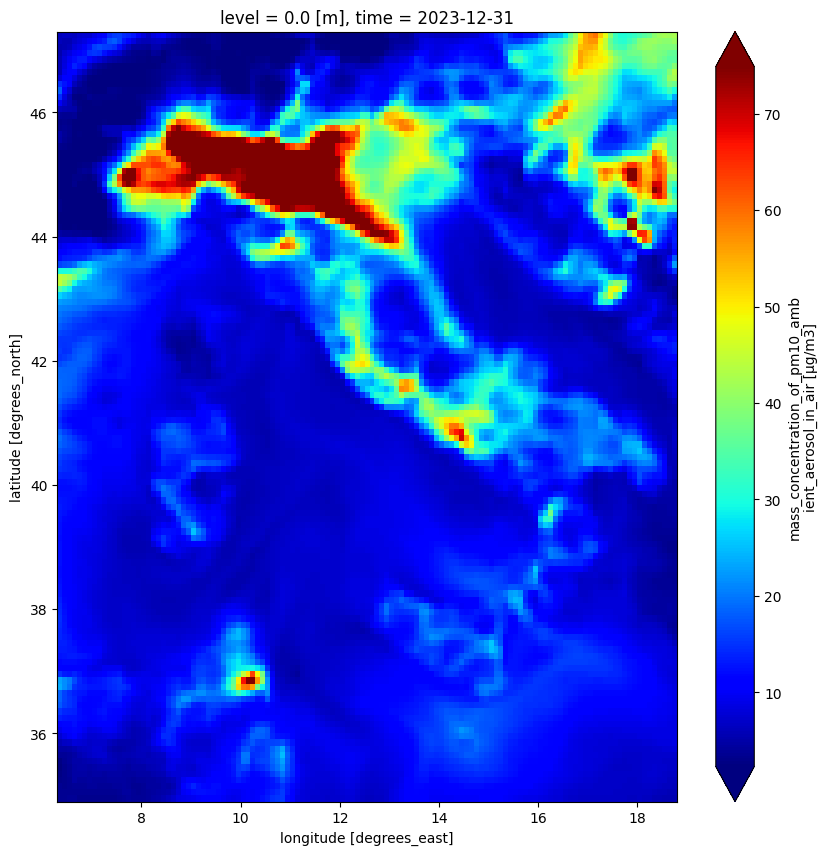

In [12]:
fig1, ax1 = plt.subplots(figsize=(10, 10))

single_data.plot(
    ax=ax1,
    cmap='jet',
    robust=True
)

plt.show()

Per orientarmi meglio aggiungerò i confini regionali di [ISTAT al 2023](https://www.istat.it/it/archivio/222527) che essendo in 32632 devo riproiettare in 4326 per poterli vedere su mappa insieme con dato sulla PM10.

In [13]:
boundaries_data = gpd.read_file(boundaries_path).to_crs('EPSG:4326')

boundaries_data

,COD_RIP,COD_REG,DEN_REG,Shape_Leng,Shape_Area,geometry
0,1,1,Piemonte,1.236800e+06,2.539388e+10,"POLYGON ((8.44976 46.46176, 8.46176 46.45081, ..."
1,1,2,Valle d'Aosta,3.109681e+05,3.258838e+09,"POLYGON ((7.58857 45.97075, 7.58981 45.97073, ..."
2,1,3,Lombardia,1.410223e+06,2.386232e+10,"MULTIPOLYGON (((8.81642 45.02231, 8.81427 45.0..."
3,2,4,Trentino-Alto Adige,8.008937e+05,1.360755e+10,"POLYGON ((12.20511 47.08653, 12.20668 47.08627..."
4,2,5,Veneto,1.054587e+06,1.834355e+10,"POLYGON ((12.50591 46.67839, 12.50603 46.67803..."
5,2,6,Friuli Venezia Giulia,6.708207e+05,7.934116e+09,"MULTIPOLYGON (((13.77538 45.61068, 13.77538 45..."
6,1,7,Liguria,8.196598e+05,5.414542e+09,"MULTIPOLYGON (((9.85132 44.02340, 9.85122 44.0..."
7,2,8,Emilia-Romagna,1.180343e+06,2.249987e+10,"MULTIPOLYGON (((10.48080 44.18949, 10.48069 44..."
8,3,9,Toscana,1.306243e+06,2.298404e+10,"MULTIPOLYGON (((11.11471 42.25911, 11.11625 42..."
9,3,10,Umbria,6.197684e+05,8.464380e+09,"MULTIPOLYGON (((12.43119 43.59136, 12.43030 43..."


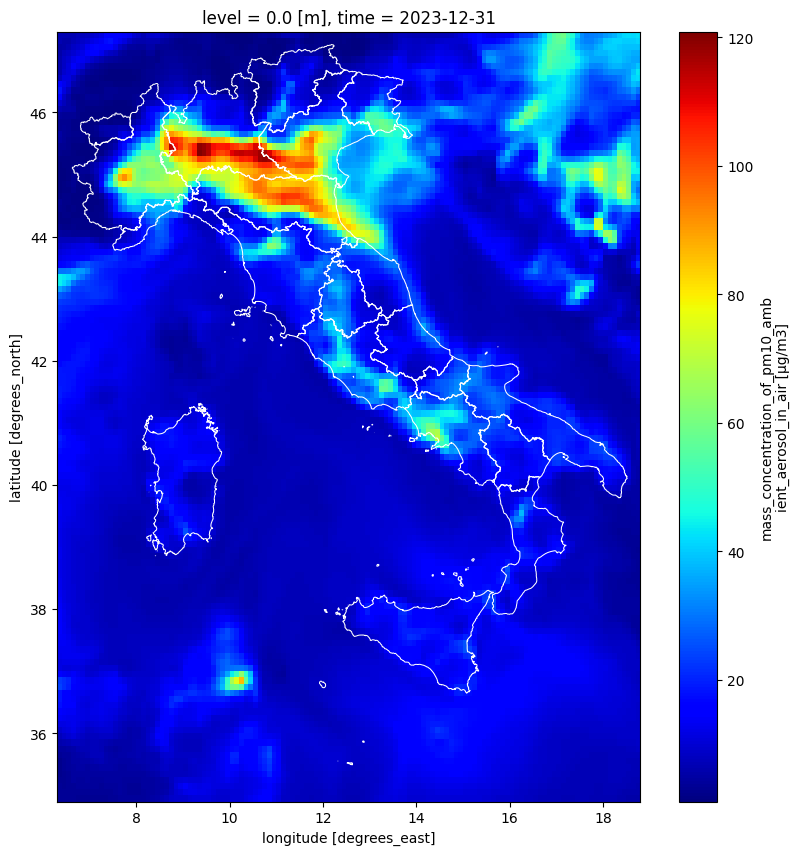

In [14]:
fig2, ax2 = plt.subplots(figsize=(10, 10))
plt.title("Concentrazione di pm10")

single_data.plot(
    ax=ax2,
    cmap='jet',
)
boundaries_data.boundary.plot(
    ax=ax2,
    edgecolor='white',
    linewidth=0.75
)

plt.show()

L'immagine ci dice che all'1 di notte di sabato 31 dicembre 2023 in Pianura Padana si producevano più di 100 µg/m3 di PM10.

## Analisi delle 48h

In precedenza abbiamo capito come interagire con un NetCDF e coome estrarre i dati di nostro insteresse. Di seguito andrò a lavorare sul livello 0 metri e sull'intera temporalità del dato andando a generare una immagine per ora.

In [15]:
netcdf_lvl0 = new_netcdf_data[dict(level=[0])]

pm10 = netcdf_lvl0['pm10_conc']

pm10

<xarray.DataArray 'pm10_conc' (time: 48, level: 1, latitude: 124, longitude: 125)>
[744000 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 6.35 6.45 6.55 6.65 ... 18.55 18.65 18.75
  * latitude   (latitude) float32 47.25 47.15 47.05 46.95 ... 35.15 35.05 34.95
  * level      (level) float32 0.0
  * time       (time) datetime64[ns] 2023-12-31 ... 2024-01-01T23:00:00
Attributes:
    species:        PM10 Aerosol
    units:          µg/m3
    value:          hourly values
    standard_name:  mass_concentration_of_pm10_ambient_aerosol_in_air

In [16]:
min_pm10 = round(float(pm10.min().values), 2)
max_pm10 = round(float(pm10.max().values), 2)
mean_pm10 = round(float(pm10.mean().values), 2)
std_pm10 = round(float(pm10.std().values), 2)

f"Concentrazioni di PM10[µg/m3] min: {min_pm10}, max: {max_pm10}, mean: {mean_pm10}, std: {std_pm10}"

'Concentrazioni di PM10[µg/m3] min: 0.65, max: 174.85, mean: 13.52, std: 11.11'

In [17]:
for single_object in pm10:
    object_date = from_datetime64_to_datetime(single_object.coords['time'].values)
    map_title = f"Concentrazione di {single_object.attrs['species'].split(' ')[0]} a 0m di quota | {object_date}"
    map_subtitle = f"Tra il 31-12-2023 e 01-01-2024\n la concentrazione massima è stata {max_pm10} µg/m3\n e la minima {min_pm10} µg/m3"

    fig4, ax4 = plt.subplots(figsize=(10, 10))
    
    single_object.plot(
        ax=ax4,
        cmap='jet',
        vmin=min_pm10,
        vmax=max_pm10,
        #robust=True,
    )
    boundaries_data.boundary.plot(
        ax=ax4,
        edgecolor='white',
        linewidth=0.75
    )
    
    plt.title(map_subtitle)
    plt.suptitle(map_title)
    plt.savefig(pm10_img.joinpath(f"pm10_{object_date}.png"))
    plt.close()


## Animazione dei dati

In precedenza ho estratto e salvato in una apposita cartella le immagini orarie che riproducono la diffusione di PM10 sul territorio italiano nel periodo temporale di riferimento.

Mi è sembrato interessante fare uno step in più che esula dalla comprensione su come si gestisce un `.nc` e cioè provare ad animare le immagini creando una [GIF](https://it.wikipedia.org/wiki/Graphics_Interchange_Format). Per fare ciò mi servirà `Pillow` ed in particolare la funzione `save`; [qui](https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif) il link alla documentazione ufficiale.

In [18]:
pm10_images = [img for img in pm10_img.glob(pattern='*.png')]

pm10_images

[PosixPath('/home/max/Desktop/DEV/PyGIS-Blog/notebooks/2024/01/06/img_pm10/pm10_2024-01-01 15:00:00.png'),
 PosixPath('/home/max/Desktop/DEV/PyGIS-Blog/notebooks/2024/01/06/img_pm10/pm10_2024-01-01 00:00:00.png'),
 PosixPath('/home/max/Desktop/DEV/PyGIS-Blog/notebooks/2024/01/06/img_pm10/pm10_2024-01-01 17:00:00.png'),
 PosixPath('/home/max/Desktop/DEV/PyGIS-Blog/notebooks/2024/01/06/img_pm10/pm10_2023-12-31 12:00:00.png'),
 PosixPath('/home/max/Desktop/DEV/PyGIS-Blog/notebooks/2024/01/06/img_pm10/pm10_2023-12-31 17:00:00.png'),
 PosixPath('/home/max/Desktop/DEV/PyGIS-Blog/notebooks/2024/01/06/img_pm10/pm10_2024-01-01 02:00:00.png'),
 PosixPath('/home/max/Desktop/DEV/PyGIS-Blog/notebooks/2024/01/06/img_pm10/pm10_2023-12-31 23:00:00.png'),
 PosixPath('/home/max/Desktop/DEV/PyGIS-Blog/notebooks/2024/01/06/img_pm10/pm10_2023-12-31 01:00:00.png'),
 PosixPath('/home/max/Desktop/DEV/PyGIS-Blog/notebooks/2024/01/06/img_pm10/pm10_2024-01-01 08:00:00.png'),
 PosixPath('/home/max/Desktop/DEV/PyG

In [19]:
print(f"Immagini totali: {len(pm10_images)}")

Immagini totali: 48


In [20]:
from PIL import Image

def build_gif(imgs_folder, duration: int = 100):
    frame_list = [Image.open(img) for img in imgs_folder.glob(pattern='*.png')]

    duration_frame = [duration for frame in range(0, len(frame_list))]
    
    first_frame = frame_list[0]
    
    first_frame.save(
        fp=imgs_folder.joinpath('pm10.gif'), 
        save_all=True,
        append_images=frame_list[1:],
        duration=duration_frame,
        loop=None,
    )

In [21]:
build_gif(
    imgs_folder=pm10_img,
    duration=500
    )

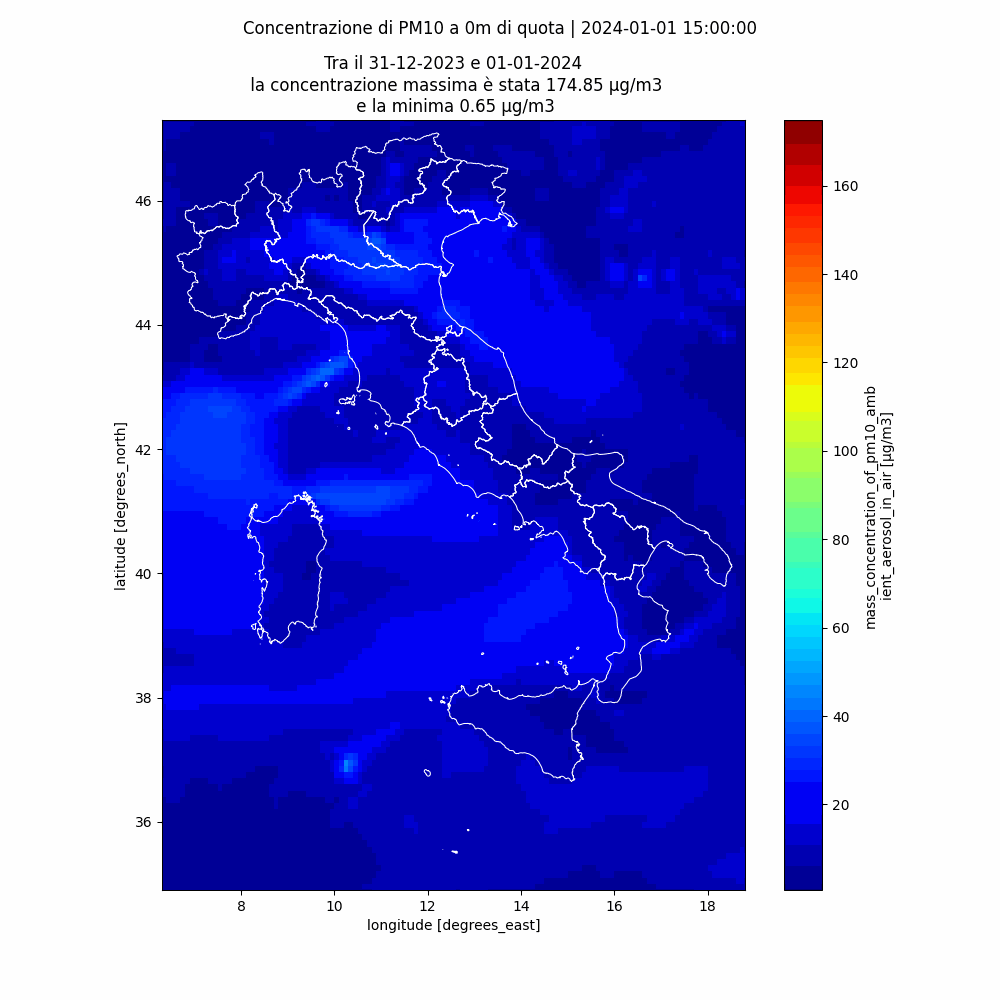

In [22]:
from IPython.display import Image as img_open

img_open(open(pm10_img.joinpath('pm10.gif'), 'rb').read())

## Conclusione

Abbiamo visto non solo come poter leggere e gestire un file `.nc` ma anche come animare le immagini che eventualmente estraiamo dal file. Come abbiamo visto, la gestione di una file di questa tipologia non è immediata e spesso dobbiamo inventarci degli stratagemmi per poter ottenere in output quello che a noi interessa.